In [9]:
from __future__ import absolute_import
###
import SimpleITK as sitk
#from lib.SimpleITK import SimpleITK as sitk
import matplotlib.pyplot as plt
import warnings
from time import time
#import numba
import cv2 
import numpy as np
#from lib.myshow import myshow, myshow3d
#from lib.thinning import Skeleton
from lib.segWormPython.mainSegworm import get_contour_angles,getSkeleton
from utils import process_config,frame_factory,frame_diff,thresh_otsu,concatenate,resize_and_gray,show_img,open_op,PIL_filter,\
plt_show,shape_filter,fill_holes,geodesicActiveContourSegementation
from curvature import curvature_grad
%matplotlib inline
from ipywidgets import interact, FloatSlider
params=process_config('..\\config.cfg')
#params['video_path']='..\\data\\5.avi'
filters=PIL_filter('EDGE_ENHANCE_MORE')
frames=frame_factory(params)
activecontour=geodesicActiveContourSegementation(params)
fgbg = cv2.createBackgroundSubtractorMOG2()

In [10]:
gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
gradientMagnitude.SetSigma(3)

In [11]:
color = [
(241,242,224), (196,203,128), (136,150,0), (64,77,0), 
(201,230,200), (132,199,129), (71,160,67), (32,94,27),
(130,224,255), (7,193,255), (0,160,255), (0,111,255),
(220,216,207), (174,164,144), (139,125,96), (100,90,69),
(252,229,179), (247,195,79), (229,155,3), (155,87,1),
(231,190,225), (200,104,186), (176,39,156), (162,31,123),
(210,205,255), (115,115,229), (80,83,239), (40,40,198)]
# Color Names
color_name = [
'teal01', 'teal02', 'teal03', 'teal04',
'green01', 'green02', 'green03', 'green04',
'amber01', 'amber02', 'amber03', 'amber04',
'bluegrey01', 'bluegrey02', 'bluegrey03', 'bluegrey04',
'lightblue01', 'lightblue02', 'lightblue03', 'lightblue04',
'purple01', 'purple02', 'purple03', 'purple04',
'red01', 'red02', 'red03', 'red04']
color_map={}
for i in range(len(color_name)):
    color_map[color_name[i]]=color[i]
def plot_worm(img,body_data,undetected=True):
    skeleton, ske_len, cnt_side1, cnt_side2, cnt_widths, cnt_area=body_data
    skeleton=skeleton.astype(np.int)
    cnt_side1=cnt_side1.astype(np.int)
    cnt_side2=cnt_side2.astype(np.int)
    if undetected:
        cv2.polylines(img, [skeleton], False, color_map['teal04'][::-1], 1)
        cv2.polylines(img, [cnt_side1], False, color_map['green04'][::-1], 1)
        cv2.polylines(img, [cnt_side2], False, color_map['purple04'][::-1], 1)
        cv2.circle(img,(skeleton[0][0],skeleton[0][1]), 2,  color_map['amber04'][::-1], -1)
        cv2.circle(img,(skeleton[-1][0],skeleton[-1][1]), 2,  color_map['lightblue04'][::-1], -1)
    else:
        cv2.polylines(img, [skeleton], False, color_map['red04'][::-1], 1)
        cv2.polylines(img, [cnt_side1], False, color_map['red04'], 1)
        cv2.polylines(img, [cnt_side2], False, color_map['red04'], 1)
        cv2.circle(img,(skeleton[0][0],skeleton[0][1]), 2,  color_map['red04'][::-1], -1)
        cv2.circle(img,(skeleton[-1][0],skeleton[-1][1]), 2,  color_map['red04'][::-1], -1)
    return img
def _curvature_fun(x_d, y_d, x_dd, y_dd):
    return (x_d*y_dd - y_d*x_dd)/(x_d*x_d + y_d*y_d)**1.5

def _gradient_windowed(X, points_window, axis):
    '''
    Calculate the gradient using an arbitrary window. The larger window make 
    this procedure less noisy that the numpy native gradient.
    '''
    w_s = 2*points_window
    
    #I use slices to deal with arbritary dimenssions 
    #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
    n_axis_ini = max(0, axis)
    n_axis_fin = max(0, X.ndim-axis-1)
    right_slice = [slice(None, None, None)]*n_axis_ini + [slice(None, -w_s, None)]
    left_slice = [slice(None, None, None)]*n_axis_ini + [slice(w_s, None, None)]
    
    right_pad = [(0,0)]*n_axis_ini + [(w_s, 0)] + [(0,0)]*n_axis_fin
    left_pad = [(0,0)]*n_axis_ini + [(0, w_s)] + [(0,0)]*n_axis_fin
    
    right_side = np.pad(X[right_slice], right_pad, 'edge')
    left_side = np.pad(X[left_slice], left_pad, 'edge')
    
    ramp = np.full(X.shape[axis]-2*w_s, w_s*2)
    
    ramp = np.pad(ramp,  pad_width = (w_s, w_s),  mode='linear_ramp', end_values = w_s)
    #ramp = np.pad(ramp,  pad_width = (w_s, w_s),  mode='constant', constant_values = np.nan)
    ramp_slice = [None]*n_axis_ini + [slice(None, None, None)] + [None]*n_axis_fin
                 
    grad = (left_side - right_side) / ramp[ramp_slice] #divide it by the time window
    
    return grad

def compute_curvature_grad(curve, points_window=None, axis=1, is_nan_border=True):
    '''
    Calculate the curvature using the gradient using differences similar to numpy grad
    
    x1, x2, x3
    
    grad(x2) = (x3-x1)/2
    
    '''
    
    #The last element must be the coordinates
    assert curve.shape[-1] == 2
    assert axis != curve.ndim - 1    
    
    if points_window is None:
        points_window = 1
    
    if curve.shape[1] <= points_window*4:
        return np.full((curve.shape[0], curve.shape[1]), np.nan)
    
    d = _gradient_windowed(curve, points_window, axis=axis)
    dd = _gradient_windowed(d, points_window, axis=axis)
    gx = d[..., 0]
    gy = d[..., 1]
    ggx = dd[..., 0]
    ggy = dd[..., 1]
    
    curvature_r =  _curvature_fun(gx, gy, ggx, ggy)
    if is_nan_border:
        #I cannot really trust in the border gradient
        w_s = 4*points_window
        n_axis_ini = max(0, axis)
        right_slice = [slice(None, None, None)]*n_axis_ini + [slice(None, w_s, None)]
        left_slice = [slice(None, None, None)]*n_axis_ini + [slice(-w_s, None, None)]
        curvature_r[right_slice] = np.nan
        curvature_r[left_slice] = np.nan
    
    return curvature_r
def get_length(skeletons):
    '''
    Calculate length using the skeletons
    '''
    
    delta_coords = np.diff(skeletons, axis=1)
    segment_sizes = np.linalg.norm(delta_coords, axis=2)
    w_length = np.sum(segment_sizes, axis=1)
    return w_length
#@numba.jit
def fillfnan(arr):
    '''
    fill foward nan values (iterate using the last valid nan)
    I define this function so I do not have to call pandas DataFrame
    '''
    out = arr.copy()
    for idx in range(1, out.shape[0]):
        if np.isnan(out[idx]):
            out[idx] = out[idx - 1]
    return out
def fillbnan(arr):
    '''
    fill foward nan values (iterate using the last valid nan)
    I define this function so I do not have to call pandas DataFrame
    '''
    out = arr.copy()
    for idx in range(out.shape[0]-1)[::-1]:
        if np.isnan(out[idx]):
            out[idx] = out[idx+1]
    return out
def nanunwrap(x):
    '''correct for phase change for a vector with nan values 
    '''
    bad = np.isnan(x)
    x = fillfnan(x)
    x = fillbnan(x)
    x = np.unwrap(x)
    x[bad] = np.nan
    return x

def _curvature_angles(skeletons, window_length = None, lengths=None):
    if window_length is None:
        window_length = 7

    points_window = int(round(window_length/2))
    
    def _tangent_angles(skels, points_window):
        '''this is a vectorize version to calculate the angles between segments
        segment_size points from each side of a center point.
        '''
        s_center = skels[:, points_window:-points_window, :] #center points
        s_left = skels[:, :-2*points_window, :] #left side points
        s_right = skels[:, 2*points_window:, :] #right side points
        
        d_left = s_left - s_center 
        d_right = s_center - s_right
        
        #arctan2 expects the y,x angle
        ang_l = np.arctan2(d_left[...,1], d_left[...,0])
        ang_r = np.arctan2(d_right[...,1], d_right[...,0])
        
        with warnings.catch_warnings():
            #I am unwraping in one dimension first
            warnings.simplefilter("ignore")
            ang = np.unwrap(ang_r-ang_l, axis=1);
        
        for ii in range(ang.shape[1]):
            ang[:, ii] = nanunwrap(ang[:, ii])
        return ang
    
    if lengths is None:
        #caculate the length if it is not given
        lengths = get_length(skeletons)
    
    #Number of segments is the number of vertices minus 1
    n_segments = skeletons.shape[1] -1 
    
    #This is the fraction of the length the angle is calculated on
    length_frac = 2*(points_window-1)/(n_segments-1)
    segment_length = length_frac*lengths
    segment_angles = _tangent_angles(skeletons, points_window)
    
    curvature = segment_angles/segment_length[:, None]
    
    return curvature
def getbackground(bk):
    itk_img=sitk.GetImageFromArray(bk)
    gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
    gradientMagnitude.SetSigma(3.)
    featureImage = sitk.BoundedReciprocal( gradientMagnitude.Execute(itk_img))
    return sitk.GetArrayFromImage(featureImage)

In [12]:
for i in range(frames.num_frames):
    img,gray=resize_and_gray(frames[i],True)
    #gray=filters.filter(gray).astype(np.uint8)
    #gray=filter_img.filter(gray)
    fgmask = fgbg.apply(gray)

In [13]:
frames=frame_factory(params)
for i in range(frames.num_frames):
    img,gray=resize_and_gray(frames[i],True)
    #gray=filter_img.filter(gray)
    fgmask = fgbg.apply(gray)
    diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
    ret, bg = cv2.threshold(fgmask,126,255,cv2.THRESH_BINARY)
    gray=filters.filter(gray).astype(np.uint8)+diff
    #cv2.imshow('gray',gray)
    contour,otsu=activecontour.execute(diff+cv2.Canny(diff,10,70)+bg)
    itk_gray=sitk.GetImageFromArray(gray)
    #myshow(contour)
    label_contour=sitk.LabelOverlay(itk_gray, contour)
    label_contour=sitk.GetArrayFromImage(label_contour)
    
    #print label_contour.shape,gray.shape
    cv2.putText(label_contour, 'frame index: ' + str(i), (40, 40), 2, 2, (0,0,0), thickness = 2)
    cv2.imshow('bs',concatenate(label_contour,otsu))
    k = cv2.waitKey(0) 
    if k == 27:
        break
    else:
        continue
cv2.destroyAllWindows()
#bk=fgbg.getBackgroundImage()
#plt_show(bk)


In [14]:
frames=frame_factory(params)
[frames[i] for i in range(60)]
prev_skeleton=np.zeros(0)
up=False
counter=0
flag_counter=0
prev=0
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('output.avi',fourcc, 10, (1600,600))
print(frames.fps,frames.size)
for i in range(60,frames.num_frames):
    begin=time()
    img,gray=resize_and_gray(frames[i],True)
    #gray=filter_img.filter(gray)
    fgmask = fgbg.apply(gray)
    diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
    ret, bg = cv2.threshold(fgmask,126,255,cv2.THRESH_BINARY)
    gray=filters.filter(gray).astype(np.uint8)+diff

    contour=activecontour.execute_v1(gray,bg)
    #itk_gray=sitk.GetImageFromArray(gray)
    #myshow(contour)
    #label_contour=sitk.LabelOverlay(itk_gray, contour)
    label_contour=sitk.GetArrayFromImage(contour).astype(np.uint8)
    #label_contour[label_contour==1]=255
    
    #plt_show(label_contour)
    (_,cnts, _) = cv2.findContours(label_contour.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #mask=np.zeros(contour.shape)
    #plt_show(cv2.drawContours(mask,cnts[0],-1,255,2))
    if len(cnts)==0:
        continue
    cnts2=np.squeeze(cnts[0], axis=1)
    output=getSkeleton(cnts2,prev_skeleton=prev_skeleton)
    skeleton=output[0].copy()
    
    if len(skeleton)==0:
        continue
    prev_skeleton=output[0]
    assert(len(skeleton)==49)
    cur=_curvature_angles(skeleton[None,:,:])[0]
    undetected=True
    if up :
        if cur[-3]<prev:
            flag_counter=flag_counter+1 
            if flag_counter==2:
                counter=counter+1
                undetected=False
                up=False
                flag_counter=0
        else:
            flag_counter=0
    else:
        if cur[-3]>prev:
            flag_counter=flag_counter+1
            if flag_counter==2:
                up=True
                flag_counter=0 
        else:
            flag_counter=0
            
    worm=plot_worm(img.copy(),output,undetected=undetected)
    prev=cur[-3]
    cv2.putText(worm, 'frame index: ' + str(i)+' counter: '+str(counter), (40, 40), 4, 1, (0,0,0), thickness = 2)
    showImg=np.concatenate([img,worm],axis=1)
    #print(showImg.shape)
    videoWriter.write(showImg)
    cv2.imshow('bs',showImg)
    k = cv2.waitKey(300) 
    if k == 27:
        break
    else:
        continue
    
videoWriter.release()
cv2.destroyAllWindows()


14.7054 (1600, 1200)


[  125   169   164   122   144   250   105    76   178   253   419   107
   565  6858     4    76    70   261    72    61    70    72   105   218
   365   131    60    70   374 26005     2     2     2     2  1193     2
   680]
(array([13, 29], dtype=int64),)


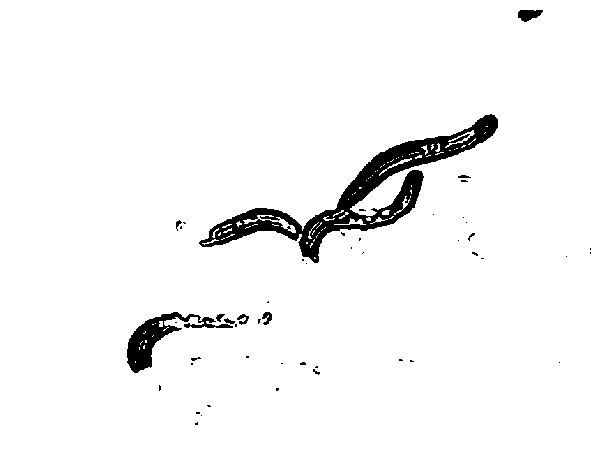

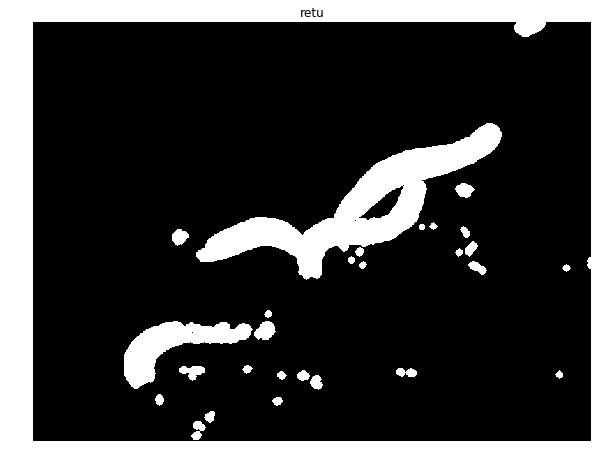

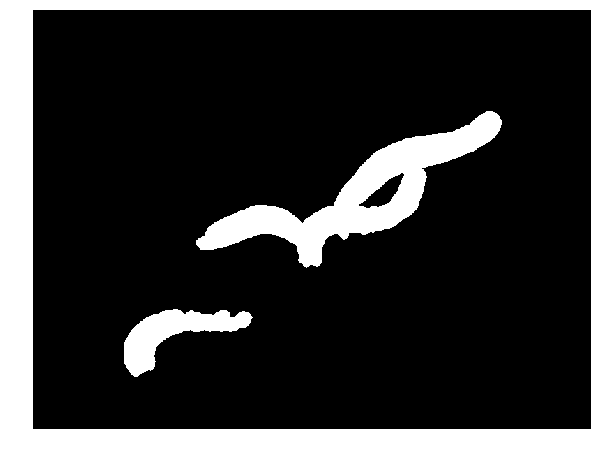

In [8]:
frames=frame_factory(params)
[frames[i] for i in range(154)]
img=frames[154]
img,gray=resize_and_gray(img,True)
plt_show(gray,u'gray')
fgmask = fgbg.apply(gray)
plt_show(fgmask,'fgmask')
plt_show(cv2.absdiff(gray,fgbg.getBackgroundImage()),'diff(gray,fgbg.getBackgroundImage())')
diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
ret, bg = cv2.threshold(fgmask,126,255,cv2.THRESH_BINARY)
plt_show(bg,'bg')
otsu=thresh_otsu(diff.copy())
plt_show(otsu)
th=cv2.Canny(diff.copy(),7,60)
contour=activecontour.execute(diff)
myshow(contour)
########################################################
bk=getbackground(diff.copy())
bk=((bk/bk.max())*255).astype(np.uint8)
otsu=thresh_otsu(bk)
plt_show(otsu)
dist_transform = cv2.distanceTransform(otsu,cv2.DIST_L2,3)
_,retu=cv2.threshold(dist_transform,5,255,cv2.THRESH_BINARY_INV)
plt_show(retu,'retu')
#filtered=shape_filter(retu.astype(np.uint8),thresh=2000)
#init_contour=open_op(shape_filtered)
retu=retu.astype(np.uint8)
(_,cnts, hier) = cv2.findContours(retu.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
areas=[(int(cv2.contourArea(c)),h[3]==-1) for (c,h) in zip(cnts,hier[0])]
areas=np.array(areas)
outer_idx=[id for id,it in enumerate(areas) if it[0]>2000 and it[1]==True]
inter_idx=[id for id,it in enumerate(areas) if it[1]==False and it[0]>10]# TODO:rewrite the code to accelerate the code using numpy
outer=[cnts[i] for i in outer_idx]
inter=[cnts[i] for i in inter_idx]
mask=np.zeros(retu.shape)
mask=cv2.drawContours(mask,outer,-1,255,-1) 
mask=cv2.drawContours(mask,inter,-1,0,-1)
plt_show(mask)
init_contour=mask.astype(np.uint)

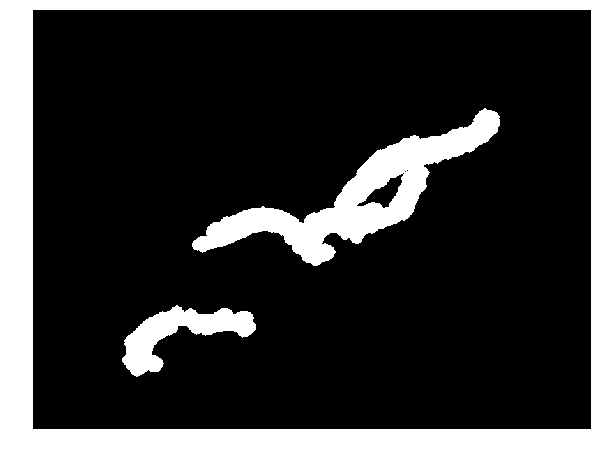

In [5]:
plt_show(activecontour.get_init_contour_v2(diff.copy()))

In [49]:
def get_init_contour(img):
    reverse=255-img
    dist_transform = cv2.distanceTransform(reverse,cv2.DIST_L2,3)
    _,ret=cv2.threshold(dist_transform,5,255,cv2.THRESH_BINARY)
    return 255-ret
def shape_filter(img,thresh=500):
    contour_list=[]
    (_,cnts, hier) = cv2.findContours(img.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    areas=[cv2.contourArea(c),h[3]==-1 for c,h in zip(cnts,hier[0])]
    outer_idx=[id for id,it in enumerate(areas) if it[0]>thresh and it[1]==True]
    inter_idx=[id for id,it in enumerate(areas) if it[0]==False and it[0]>300]# TODO:rewrite the code to accelerate the code using numpy
    outer=[cnts[i] for i in outer_idx]
    inter=[cnts[i] for i in inter_idx]
    for c in cnts:
        Area = cv2.contourArea(c)
        if Area>thresh:
            contour_list.append(c)
    mask=np.zeros(img.shape)
    mask=cv2.drawContours(mask,contour_list,-1,255,-1) 
    return mask
def fill_holes(img):
    '''
    fill holes and filter small component with small area
    '''
    #print np.unique(img)   
    h,w=img.shape
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(img.copy(),mask,(0,0),255,0,0,8)
    mask[mask==1]=255  
    mask=255-mask[1:h+1,1:w+1]
    img_filled=cv2.bitwise_or(mask,img)
    return img_filled

<h1 align="center">线虫的图像处理演示</h1>

<b>下面的代码块主要做了一下几件事情：</b>
+ <b>读取一帧视频</b>
+ <b>调整图像的大小尺寸变为原来的一半并且灰度化</b>
+ <b>更新背景像素，fgbg.apply(gray)将返回前景像素。阴影的灰度值为128，前景像素的灰度值为255.由于背景估计的不准确。导致前景目标的不连续。所以需要后续的处理</b>
+ <b>fgbg.getBackgroundImage() 将返回背景图片，与原图相减可以得到前景的灰度图</b>
+ <b>我们接下来需要对bg进行处理来得到最终的初始轮廓，用于水平集图像分割。初始轮廓应包含真正的轮廓</b>

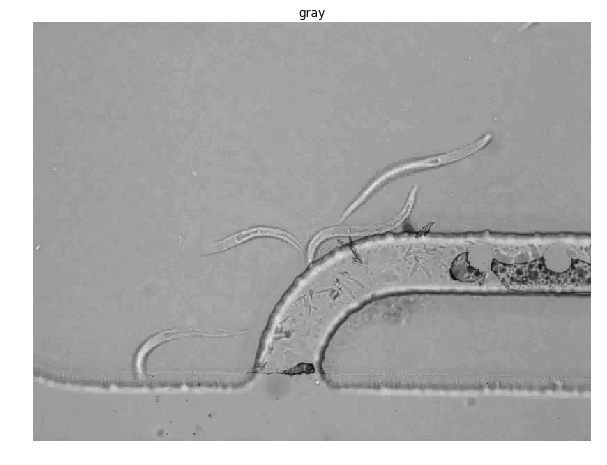

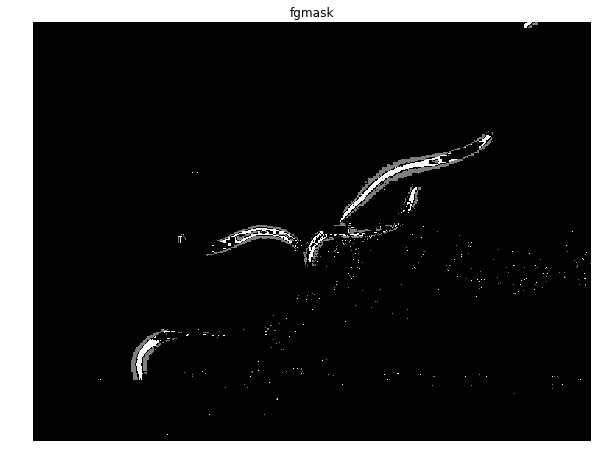

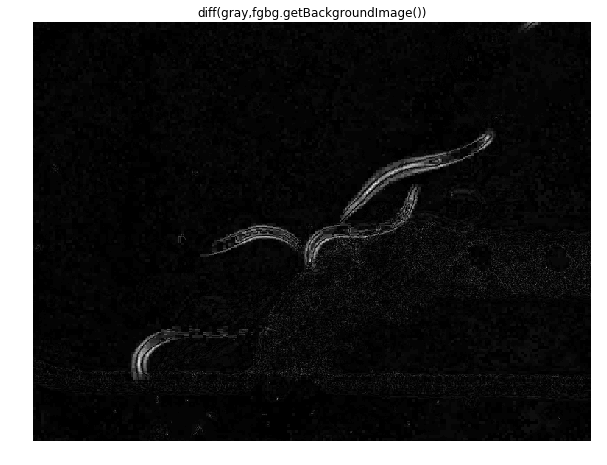

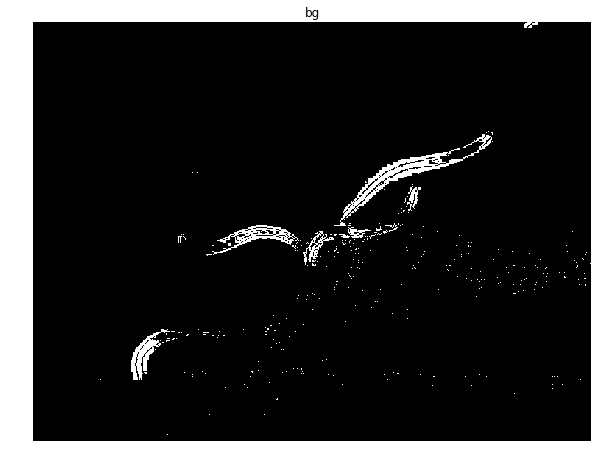

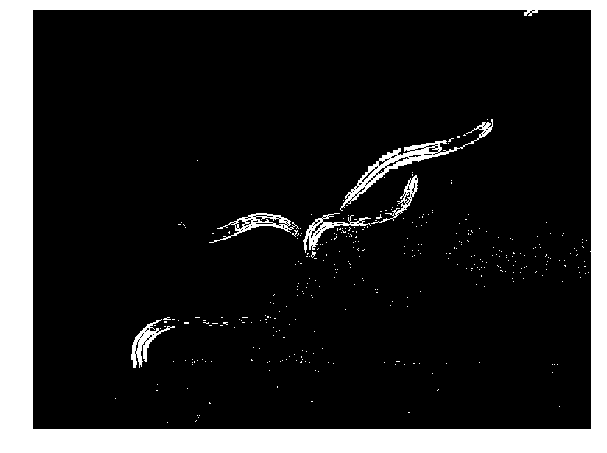

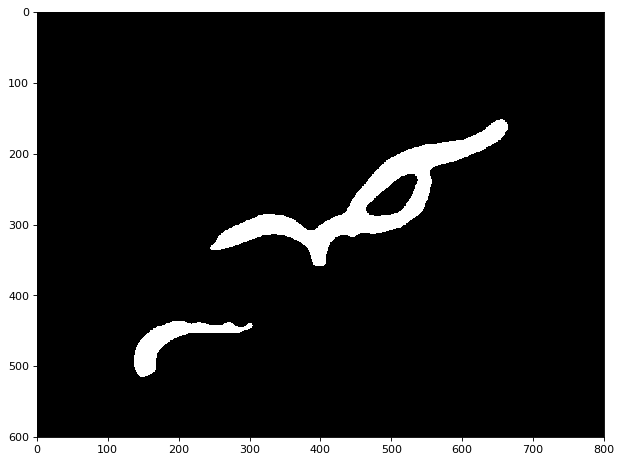

In [4]:
frames=frame_factory(params)
[frames[i] for i in range(154)]
img=frames[154]
img,gray=resize_and_gray(img,True)
plt_show(gray,u'gray')
fgmask = fgbg.apply(gray)
plt_show(fgmask,'fgmask')
plt_show(cv2.absdiff(gray,fgbg.getBackgroundImage()),'diff(gray,fgbg.getBackgroundImage())')
diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
ret, bg = cv2.threshold(fgmask,126,255,cv2.THRESH_BINARY)
plt_show(bg,'bg')
otsu=thresh_otsu(diff.copy())
plt_show(otsu)
th=cv2.Canny(diff.copy(),7,60)
contour=activecontour.execute(diff)
myshow(contour)

 ## 下面的代码块主要做了一下几件事情，为了尽可能的连接断裂的轮廓
1. <b>距离变换</b>
2. <b>闸值化</b>

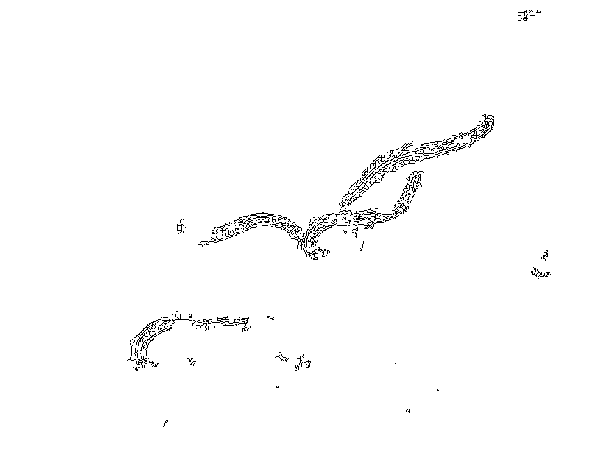

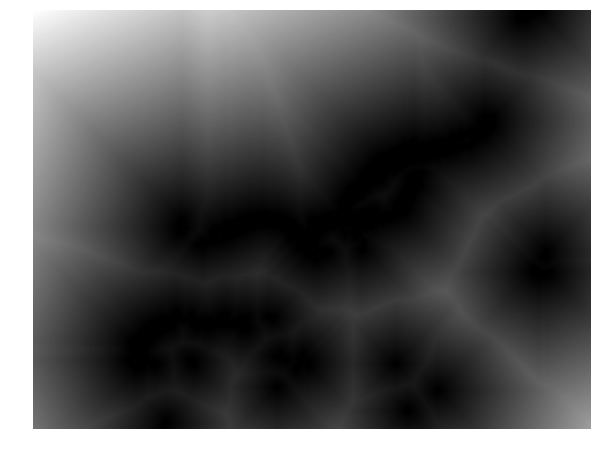

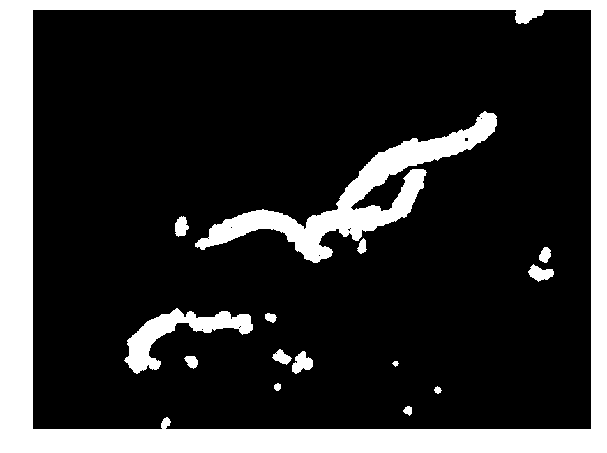

In [11]:
reverse=255-th
plt_show(reverse)
dist_transform = cv2.distanceTransform(reverse,cv2.DIST_L2,3)
plt_show(dist_transform)
_,ret=cv2.threshold(dist_transform,4,255,cv2.THRESH_BINARY_INV)
plt_show(ret)

 ## 下面的代码主要做了一下几件事：
+ <b>通过形状滤波过滤掉，面积太小的连通域</b>
+ <b>空洞填充</b>
+ <b>通过形态学闭操作，连接不连续的的部分，确保真正的轮廓被包含在里面</b>

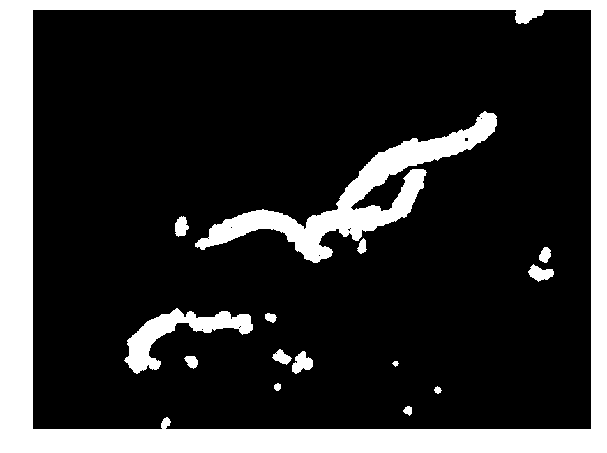

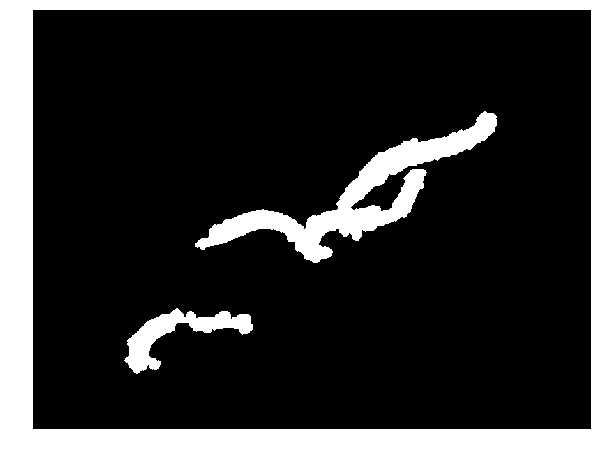

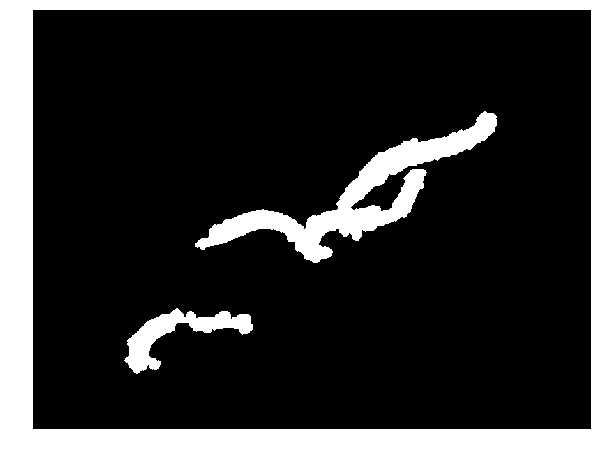

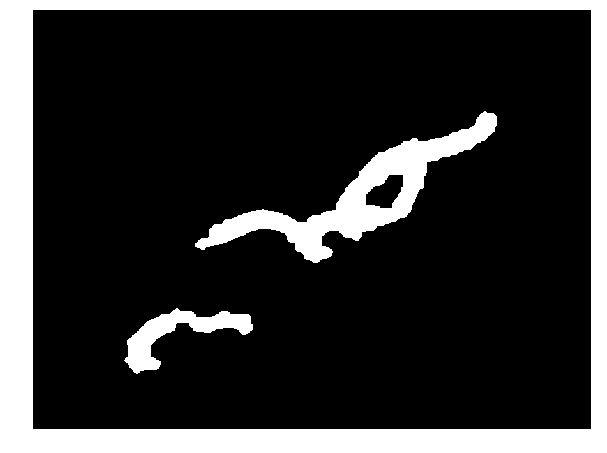

In [14]:
#ret_=255-ret
plt_show(ret)
shape_filtered=shape_filter(ret.astype(np.uint8),thresh=2000)
shape_filtered=shape_filtered.astype(np.uint8)
plt_show(shape_filtered)
#holes=fill_holes(shape_filtered)
plt_show(shape_filtered)
init_contour=cv2.morphologyEx(shape_filtered,cv2.MORPH_CLOSE,np.ones((3,3),np.uint8),iterations =7)
plt_show(init_contour)

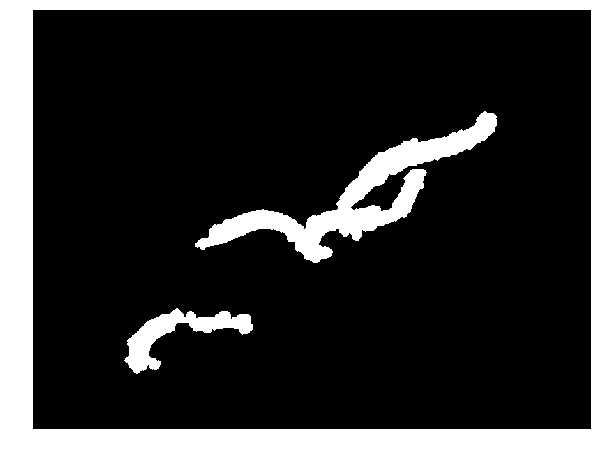

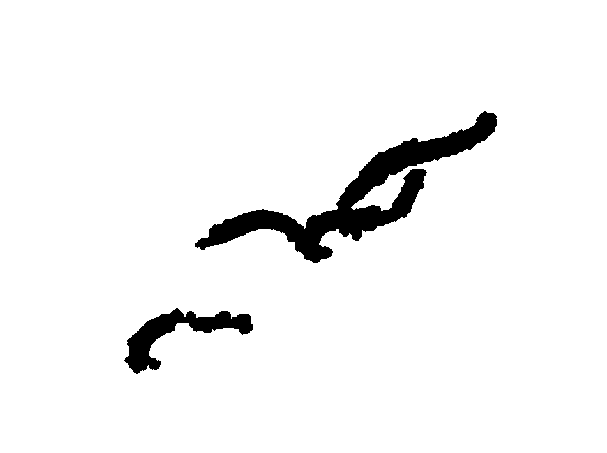

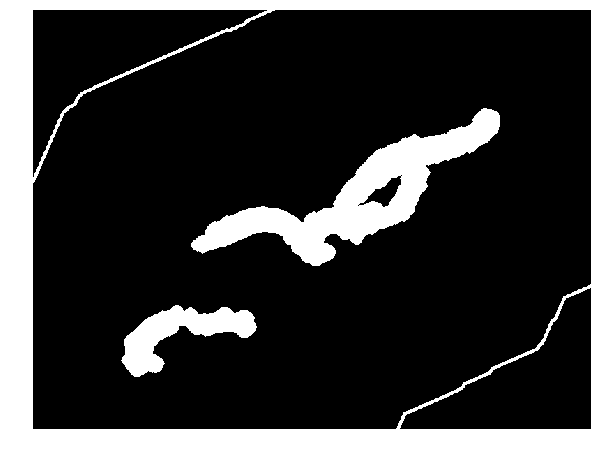

In [7]:
#ret_1=255-ret
shape_filtered=shape_filter(ret.astype(np.uint8),thresh=2000)
shape_filtered=shape_filtered.astype(np.uint8)
plt_show(shape_filtered)
#holes=fill_holes(shape_filtered)
reverse=255-shape_filtered
plt_show(reverse)
dist_transform = cv2.distanceTransform(reverse,cv2.DIST_L2,3).astype(np.uint8)
_,init_contour=cv2.threshold(dist_transform,4,255,cv2.THRESH_BINARY_INV)
plt_show(init_contour)
#init_contour=255-init_contour.astype(np.uint8)

 # 下面的程序利用The ITK Software提供的level set分割的一个类实例化一个对象并，设置其参数可以控制曲线演化过程中所受到的不同力的大小的影响。
 
 # 最下面两行为一个递归的高斯滤波器，sigma为所用核的大小

In [95]:
geodesicActiveContour = sitk.GeodesicActiveContourLevelSetImageFilter()
geodesicActiveContour.SetPropagationScaling(-2)
geodesicActiveContour.SetCurvatureScaling(0.01)
geodesicActiveContour.SetAdvectionScaling(1.5)
geodesicActiveContour.SetMaximumRMSError(0.01)
geodesicActiveContour.SetNumberOfIterations(40)
gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
gradientMagnitude.SetSigma(3)

# 下面

In [96]:
init_contour_ = sitk.GetImageFromArray(init_contour)
init_contour_1 = sitk.SignedMaurerDistanceMap(init_contour_, 
insideIsPositive=False, useImageSpacing=False)
featureImage=sitk.GetImageFromArray(diff)
featureImage = sitk.BoundedReciprocal(gradientMagnitude.Execute(featureImage))
featureImage = sitk.Cast( featureImage, init_contour_1.GetPixelID()) 
levelset = geodesicActiveContour.Execute( init_contour_1, featureImage )
contour=levelset<0

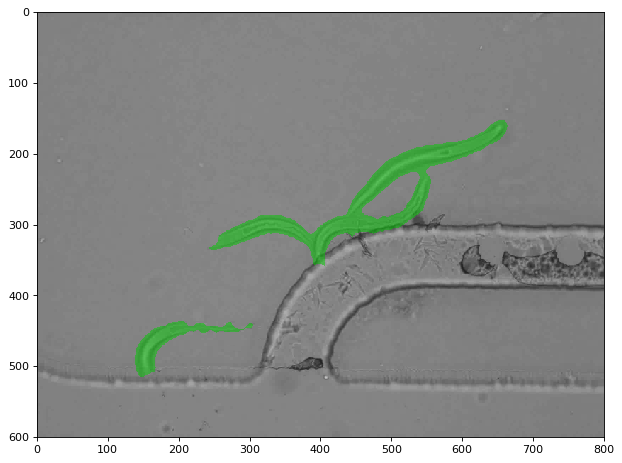

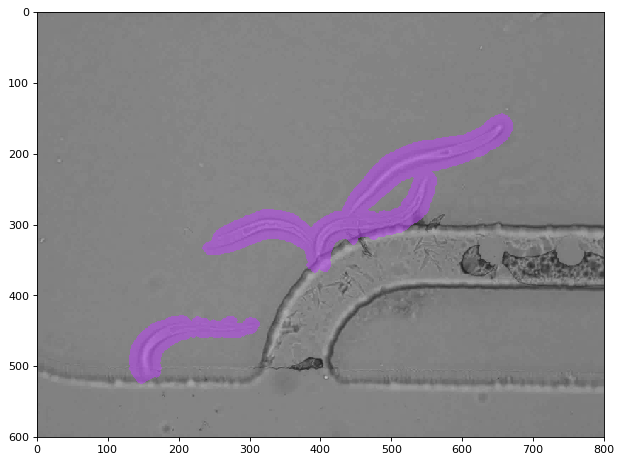

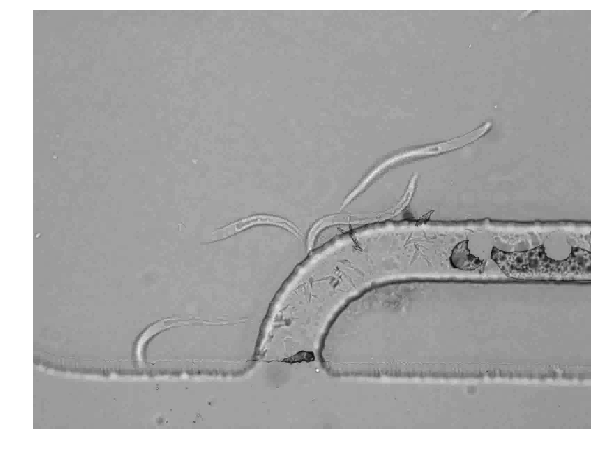

In [97]:
myshow(sitk.LabelOverlay(sitk.GetImageFromArray(gray), contour))
myshow(sitk.LabelOverlay(sitk.GetImageFromArray(gray), init_contour_))
plt_show(gray)

In [199]:
contour=sitk.GetArrayFromImage(contour)

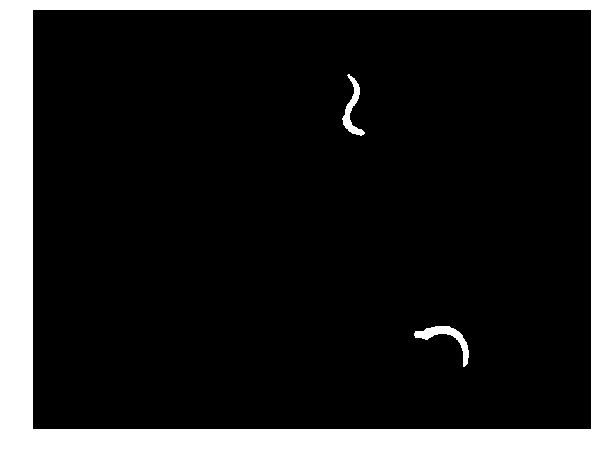

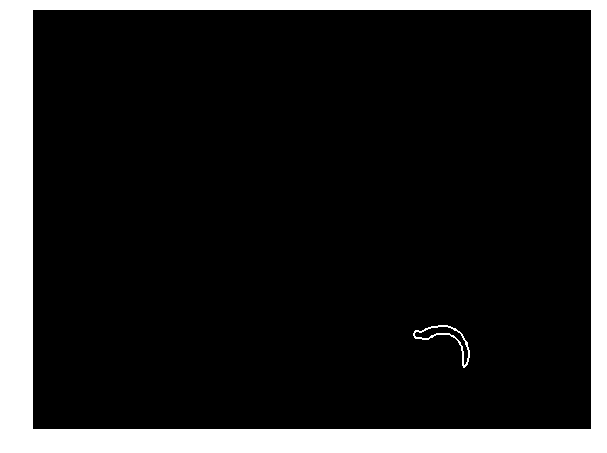

In [200]:
plt_show(contour)
(_,cnts, _) = cv2.findContours(contour.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask=np.zeros(contour.shape)
plt_show(cv2.drawContours(mask,cnts[0],-1,255,2))
cnts2=np.squeeze(cnts[0], axis=1)
output=getSkeleton(cnts2)

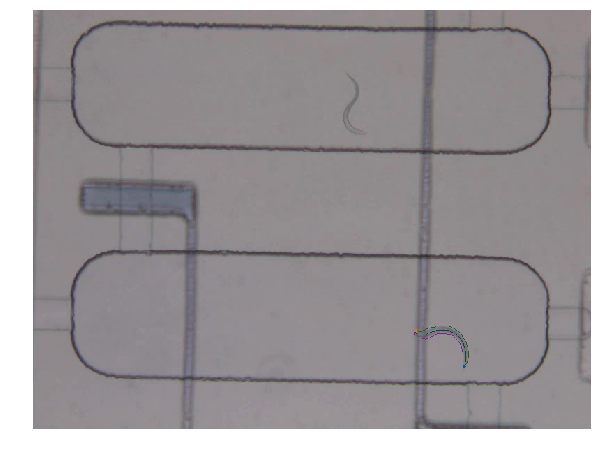

In [201]:
img=plot_worm(img,output,undetected=True)
plt_show(img)

In [169]:
cur=compute_curvature_grad(output[0][None,:,:],is_nan_border=False)
print(cur[0])

[ 0.05405392  0.04382716  0.05245112  0.02937164 -0.00373449 -0.02010384
 -0.07055633 -0.06923192 -0.03535184 -0.00957602  0.01493816  0.0317567
  0.02267661  0.01246032  0.03002205  0.02067946  0.02920652  0.02189939
  0.01940941  0.0244268   0.02520861  0.03359417  0.03197449  0.03586743
  0.03049665  0.03611317  0.02405402  0.02864219  0.04865029  0.03582636
  0.04092142  0.0268095   0.0187741   0.01752847  0.02467133  0.03305778
  0.02481193  0.03769168  0.02328744  0.01685646  0.02014867  0.0173253
  0.01765758  0.02221151  0.02091186  0.00953249  0.02312056  0.01341471
  0.0147438 ]


In [269]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetMaximumRMSError(0.02)
lsFilter.SetNumberOfIterations(100)
lsFilter.SetCurvatureScaling(1)
lsFilter.SetPropagationScaling(1)
#lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(absdiff, sitk.sitkFloat32))

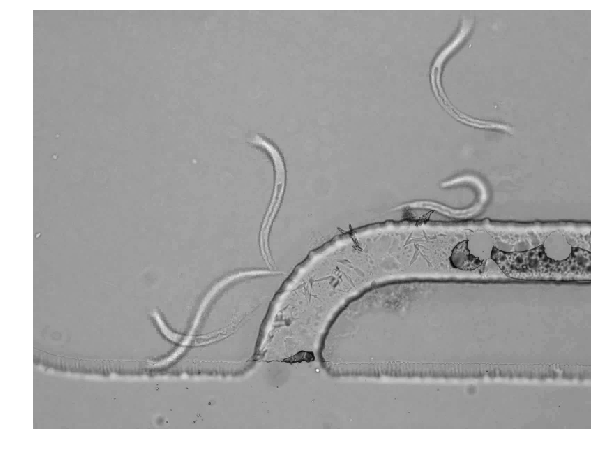

In [15]:
plt_show(gray)

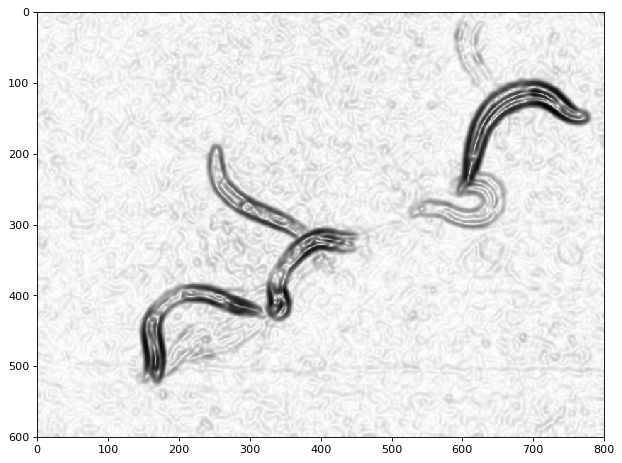

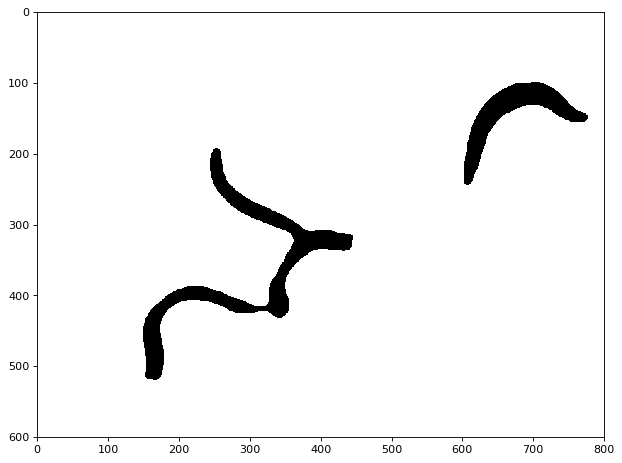

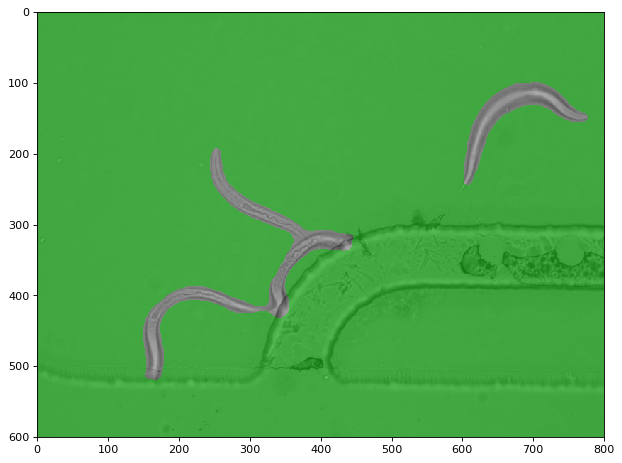

In [33]:
gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
gradientMagnitude.SetSigma(3.)
featureImage = sitk.BoundedReciprocal( gradientMagnitude.Execute( absdiff ))
featureImage = sitk.Cast( featureImage, init_ls.GetPixelID()) 
myshow(featureImage)
geodesicActiveContour = sitk.GeodesicActiveContourLevelSetImageFilter()
geodesicActiveContour.SetPropagationScaling( -0.9 )
geodesicActiveContour.SetCurvatureScaling( 1. )
geodesicActiveContour.SetAdvectionScaling( 1.0 )
geodesicActiveContour.SetMaximumRMSError( 0.01 )
geodesicActiveContour.SetNumberOfIterations( 30 )
levelset = geodesicActiveContour.Execute( init_ls, featureImage )
myshow(levelset>0)
myshow(sitk.LabelOverlay(img, levelset>0))

In [6]:
contour=activecontour.execute(diff,bg)

[  0 255]


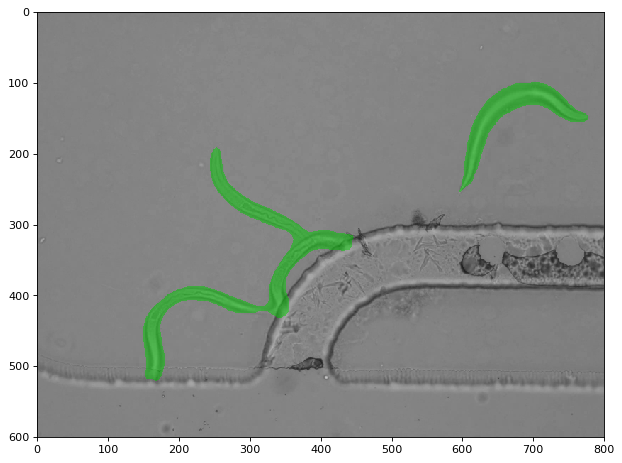

In [8]:
myshow(sitk.LabelOverlay(img, contour))

In [36]:
skeleton=sitk.GetArrayFromImage(levelset<0)

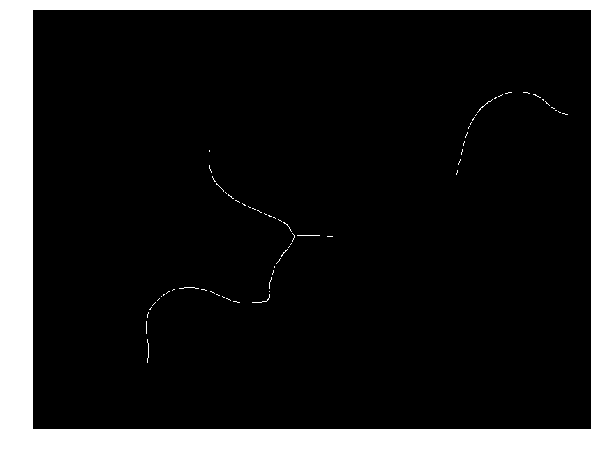

In [38]:
plt_show(Skeleton(skeleton))

In [51]:
print frames.num_frames

516
